In [1]:
# importing libraries & modules
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

## Loading stock data
---

In [2]:
google = yf.Ticker("AAPL")
google_data = google.history(period="1y")

## Visualizing stock price data over time
---

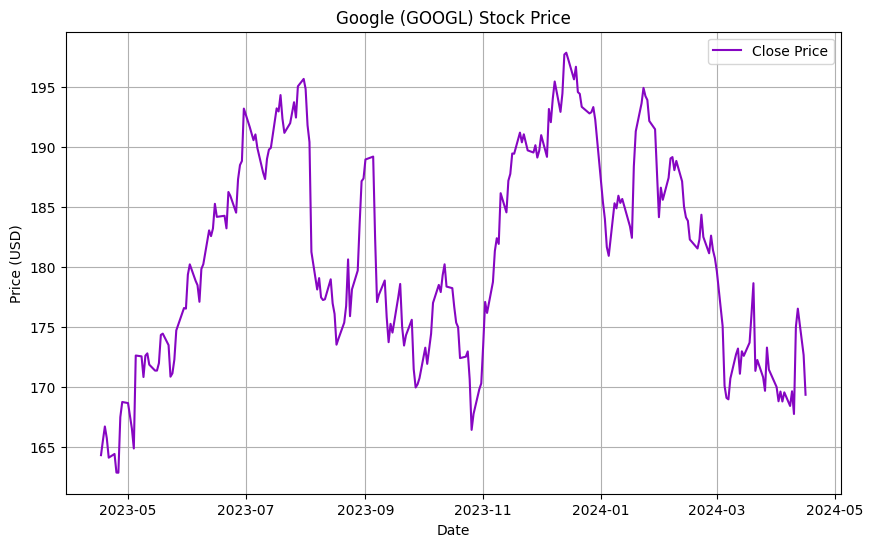

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(google_data['Close'], label='Close Price', color='#8606c2')
plt.title('Google (GOOGL) Stock Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
close_price = google_data['Close']

In [5]:
close_price.shift(1)

Date
2023-04-17 00:00:00-04:00           NaN
2023-04-18 00:00:00-04:00    164.352737
2023-04-19 00:00:00-04:00    165.586166
2023-04-20 00:00:00-04:00    166.739990
2023-04-21 00:00:00-04:00    165.765213
                                ...    
2024-04-10 00:00:00-04:00    169.669998
2024-04-11 00:00:00-04:00    167.779999
2024-04-12 00:00:00-04:00    175.039993
2024-04-15 00:00:00-04:00    176.550003
2024-04-16 00:00:00-04:00    172.690002
Name: Close, Length: 252, dtype: float64

In [6]:
returns = ((close_price - close_price.shift(1)) / close_price.shift(1)).dropna()
annual_volatility = np.std(returns) * np.sqrt(252)

print(f'Annual Volatility : {annual_volatility}')

Annual Volatility : 0.19612456103735054


##  Using 10 years' US treasury rate as the rate of interest
---

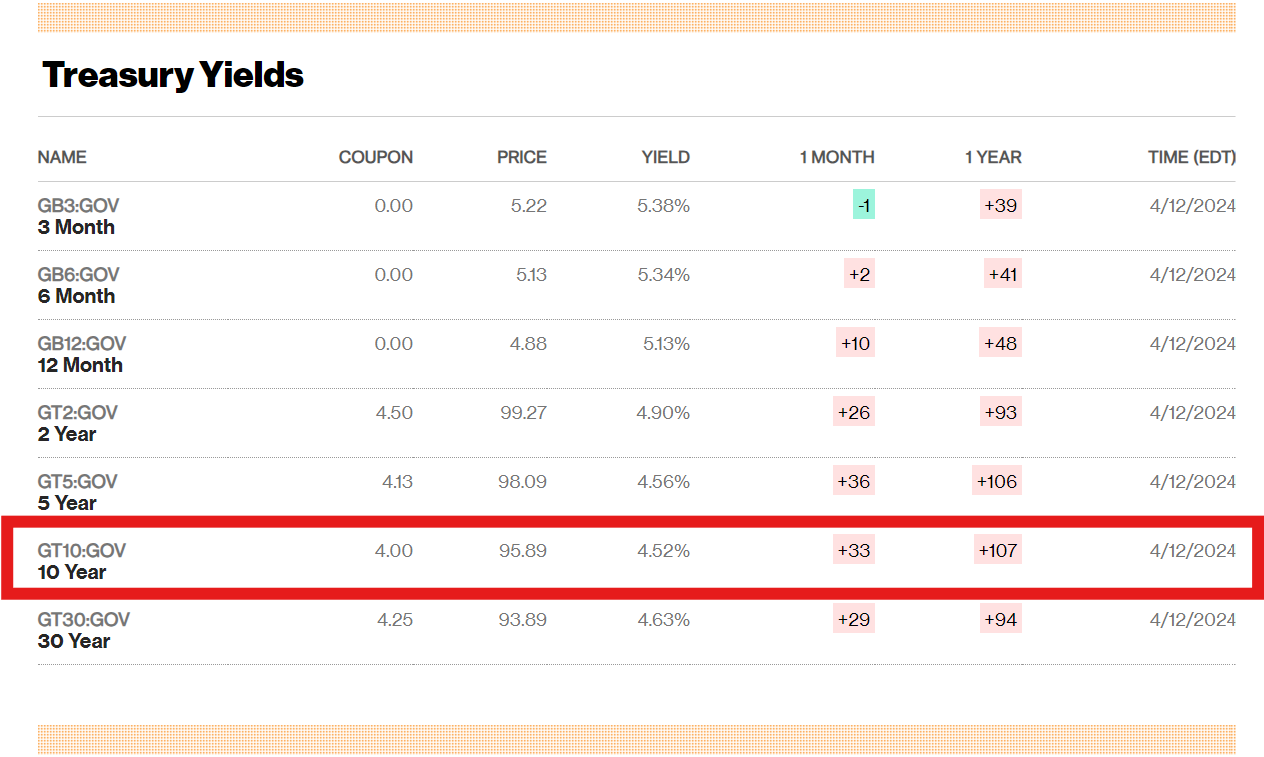

In [7]:
rate_of_interest = 4.52 / 100

In [8]:
def put_call_parity(C0, K, T, r, S0):
    '''
    returns put option price based on put-call parity
    '''
    P0 = C0 - S0 + K * np.exp(-r * T)
    return P0

## Evaluating the call / put option prices by using Binomial model
---

In [9]:
def binomial_option_pricing(S0, K, T, r, σ, n, option_type):
    """
    Calculates the option price using the Binomial option pricing model.
    -----------------
    
    Args:
        S0 (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity in years
        r (float): Risk-free interest rate
        σ (float): Annual volatility of the underlying asset
        n (int): Number of time steps
        option_type (str): 'call' or 'put'
        
    Returns:
        float: Option price
    """
    
    Δt = T / n
    u = math.exp(σ * math.sqrt(Δt))
    d = 1 / u
    p = (math.exp(r * Δt) - d) / (u - d)
    
    option_price = 0
    
    for j in range(0, n + 1):
        price_component = S0 * (u ** j) * (d ** (n - j)) - K
        prob_component = math.comb(n, j) * (p ** j) * ((1 - p) ** (n - j))
     
        if option_type == 'call':
            price = prob_component * max(0, price_component)
        elif option_type == 'put':
            price = prob_component * max(0, -price_component)
        
        option_price += price
        
    option_price = math.exp(-r * T) * option_price
    return option_price

In [10]:
S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
n = 2    # number of time steps
T = 1
K = 100

In [11]:
call_option_price = binomial_option_pricing(S0, K, T, r, σ, n, 'call')
print(f'Call option price using Binomial model : {call_option_price}')

Call option price using Binomial model : 68.772107281217


In [12]:
put_option_price = binomial_option_pricing(S0, K, T, r, σ, n, 'put')
print(f'Put option price using Binomial model : {put_option_price}')

Put option price using Binomial model : 0.0


In [13]:
C0, K, T, r, S0 = call_option_price, K, T, r, S0
put_option_price = put_call_parity(C0, K, T, r, S0)
print(f'Put option price using put call parity : {put_option_price}')

Put option price using put call parity : 2.842170943040401e-14


## Evaluating the call / put option prices by using Black Scholes formula
---

In [14]:
def black_scholes_formula(S0, K, T, r, σ, option_type):
    '''
    Calculates the option price using the Black Scholes formula.
    -----------------
    
    Args:
        S0 (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity in years
        r (float): Risk-free interest rate
        σ (float): Annual volatility of the underlying asset
        option_type (str): 'call' or 'put'
        
    Returns:
        float: Option price
    '''
    d1 = (math.log(S0 / K) + (r + (σ ** 2) / 2) * T) / (σ * math.sqrt(T))
    d2 = d1 - σ * math.sqrt(T)
    
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    C0 = S0 * N_d1 - K * math.exp(-r * T) * N_d2
    if option_type == 'call':
        return C0
    elif option_type == 'put':
        P0 = put_call_parity(C0, K, T, r, S0)
        return P0

In [15]:
S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
T = 1
K = 100

In [16]:
call_option_price = black_scholes_formula(S0, K, T, r, σ, 'call')
print(f'Call option price using Black Scholes formula : {call_option_price}')

Call option price using Black Scholes formula : 68.79313668011442


In [17]:
put_option_price = black_scholes_formula(S0, K, T, r, σ, 'put')
print(f'Put option price using Black Scholes formula : {put_option_price}')

Put option price using Black Scholes formula : 0.021029398897439933


## Evaluating option prices
---

In [18]:
K_vals = S0 + np.arange(-20, 20)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
n = 2    # number of time steps

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        call_option_price = binomial_option_pricing(S0, K, T, r, σ, n, 'call')
        print(f'T = {int(T * 12)} month(s) : Call Option price is {call_option_price}')

For K = 144.3527374267578
T = 1 month(s) : Call Option price is 20.542705906534398
T = 5 month(s) : Call Option price is 24.19533815076588
T = 9 month(s) : Call Option price is 27.885571023727927
For K = 145.3527374267578
T = 1 month(s) : Call Option price is 19.54646548821057
T = 5 month(s) : Call Option price is 23.43039615515891
T = 9 month(s) : Call Option price is 27.12255543876598
For K = 146.3527374267578
T = 1 month(s) : Call Option price is 18.55022506988674
T = 5 month(s) : Call Option price is 22.665454159551942
T = 9 month(s) : Call Option price is 26.359539853804026
For K = 147.3527374267578
T = 1 month(s) : Call Option price is 17.553984651562907
T = 5 month(s) : Call Option price is 21.90051216394497
T = 9 month(s) : Call Option price is 25.596524268842078
For K = 148.3527374267578
T = 1 month(s) : Call Option price is 16.557744233239074
T = 5 month(s) : Call Option price is 21.135570168338003
T = 9 month(s) : Call Option price is 24.83350868388013
For K = 149.3527374267

In [19]:
K_vals = S0 + np.arange(-20, 20)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
n = 2    # number of time steps

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        put_option_price = binomial_option_pricing(S0, K, T, r, σ, n,'put')
        print(f'T = {int(T * 12)} month(s) : Put Option price is {put_option_price}')

For K = 144.3527374267578
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 1.502135525480228
T = 9 month(s) : Put Option price is 3.074029632015091
For K = 145.3527374267578
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 1.718536435638021
T = 9 month(s) : Put Option price is 3.27768221367413
For K = 146.3527374267578
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 1.9349373457958141
T = 9 month(s) : Put Option price is 3.481334795333169
For K = 147.3527374267578
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 2.151338255953607
T = 9 month(s) : Put Option price is 3.684987376992208
For K = 148.3527374267578
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 2.3677391661114005
T = 9 month(s) : Put Option price is 3.888639958651247
For K = 149.3527374267578
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 2.58414007

In [20]:
K_vals = S0 + np.arange(-20, 20)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        call_option_price = black_scholes_formula(S0, K, T, r, σ, 'call')
        print(f'T = {int(T * 12)} month(s) : Put Option price is {call_option_price}')

For K = 144.3527374267578
T = 1 month(s) : Put Option price is 20.569521736219116
T = 5 month(s) : Put Option price is 23.835158526279514
T = 9 month(s) : Put Option price is 27.10238917885067
For K = 145.3527374267578
T = 1 month(s) : Put Option price is 19.584913834652582
T = 5 month(s) : Put Option price is 22.990624675723538
T = 9 month(s) : Put Option price is 26.324598214084133
For K = 146.3527374267578
T = 1 month(s) : Put Option price is 18.604542509155465
T = 5 month(s) : Put Option price is 22.158274083139148
T = 9 month(s) : Put Option price is 25.557801987532656
For K = 147.3527374267578
T = 1 month(s) : Put Option price is 17.629624956414887
T = 5 month(s) : Put Option price is 21.338716545906834
T = 9 month(s) : Put Option price is 24.802291804303024
For K = 148.3527374267578
T = 1 month(s) : Put Option price is 16.661615373560664
T = 5 month(s) : Put Option price is 20.532549012635002
T = 9 month(s) : Put Option price is 24.058345964651394
For K = 149.3527374267578
T = 1

In [21]:
K_vals = S0 + np.arange(-20, 20)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        put_option_price = black_scholes_formula(S0, K, T, r, σ, 'put')
        print(f'T = {int(T * 12)} month(s) : Put Option price is {put_option_price}')

For K = 144.3527374267578
T = 1 month(s) : Put Option price is 0.026815829684721848
T = 5 month(s) : Put Option price is 1.1419559009938496
T = 9 month(s) : Put Option price is 2.2908477871378636
For K = 145.3527374267578
T = 1 month(s) : Put Option price is 0.03844834644203843
T = 5 month(s) : Put Option price is 1.2787649562026502
T = 9 month(s) : Put Option price is 2.4797249889923023
For K = 146.3527374267578
T = 1 month(s) : Put Option price is 0.05431743926874333
T = 5 month(s) : Put Option price is 1.4277572693829939
T = 9 month(s) : Put Option price is 2.6795969290618302
For K = 147.3527374267578
T = 1 month(s) : Put Option price is 0.07564030485198714
T = 5 month(s) : Put Option price is 1.5895426379154571
T = 9 month(s) : Put Option price is 2.8907549124531897
For K = 148.3527374267578
T = 1 month(s) : Put Option price is 0.10387114032161548
T = 5 month(s) : Put Option price is 1.7647180104083873
T = 9 month(s) : Put Option price is 3.1134772394225365
For K = 149.352737426757

In [22]:
S0 = 200    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
T = 2
K = 220

black_scholes_call_price = black_scholes_formula(S0, K, T, r, σ, 'call')
print(f'Black Scholes Call Option Price : {black_scholes_call_price}')

call_prices = []

for n in range(1, 100):
    call_price = binomial_option_pricing(S0, K, T, r, σ, n, 'call')
    call_prices.append(call_price)

Black Scholes Call Option Price : 21.62506347488997


## Increasing the number of steps in Binomial model to verify that the price converges to that of Black Scholes
---

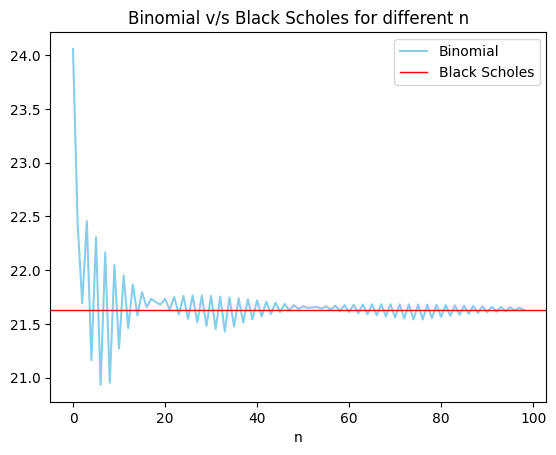

In [23]:
plt.plot(call_prices, label='Binomial', color='skyblue')
plt.axhline(black_scholes_call_price, color='red', label='Black Scholes', linewidth=1)
plt.xlabel('n')

plt.title('Binomial v/s Black Scholes for different n')
plt.legend()
plt.show()

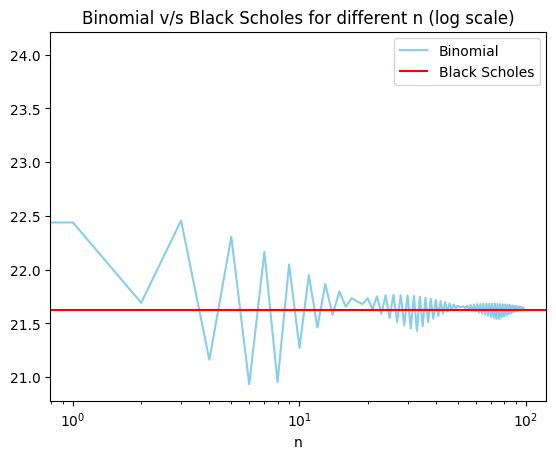

In [24]:
plt.plot(call_prices, label='Binomial', color='skyblue')
plt.axhline(black_scholes_call_price, color='red', label='Black Scholes')
plt.xlabel('n')

plt.legend()
plt.xscale('log')
plt.title('Binomial v/s Black Scholes for different n (log scale)')
plt.show()

## Comparison with actual market data
---

In [25]:
ticker_symbol = "AAPL"
options_data = yf.Ticker(ticker_symbol).options
expiry_date = options_data[0]
options_chain = yf.Ticker(ticker_symbol).option_chain(expiry_date)

calls = pd.DataFrame(options_chain.calls)
puts = pd.DataFrame(options_chain.puts)

In [26]:
try:
    calls.drop(['contractSymbol' , 'bid' , 'ask' , 'change' , 'percentChange' , 'volume' , 'openInterest' , 'inTheMoney'],axis=1 , inplace=True)
    puts.drop(['contractSymbol' , 'bid' , 'ask' , 'change' , 'percentChange' , 'volume' , 'openInterest' , 'inTheMoney'], axis=1 , inplace=True)
except Exception as e:
    print(e)

### Call Option Comparison

In [27]:
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-04-16 16:14:01+00:00,5.0,164.30,0.00001,REGULAR,USD
1,2024-03-27 19:35:59+00:00,10.0,163.00,0.00001,REGULAR,USD
2,2024-04-04 14:55:59+00:00,15.0,155.95,0.00001,REGULAR,USD
3,2024-03-27 15:14:12+00:00,30.0,142.65,0.00001,REGULAR,USD
4,2024-04-12 14:02:42+00:00,35.0,142.43,0.00001,REGULAR,USD


In [28]:
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate']).dt.date
start_date, end_date = "2023-03-28", "2024-04-01"
calls = calls[(calls['lastTradeDate'] >= pd.to_datetime(start_date).date()) & (calls['lastTradeDate'] <= pd.to_datetime(end_date).date())]
calls.reset_index(inplace = True, drop = True)
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-03-27,10.0,163.00,0.000010,REGULAR,USD
1,2024-03-27,30.0,142.65,0.000010,REGULAR,USD
2,2024-03-14,55.0,118.80,11.791995,REGULAR,USD
3,2024-03-27,60.0,112.60,0.000010,REGULAR,USD
4,2024-03-13,70.0,101.60,9.387699,REGULAR,USD


In [29]:
google_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-17 00:00:00-04:00,164.213481,164.511892,163.159112,164.352737,41516200,0.0,0.0
2023-04-18 00:00:00-04:00,165.218136,166.521178,164.770513,165.586166,49923000,0.0,0.0
2023-04-19 00:00:00-04:00,164.919705,167.267175,164.661075,166.739990,47720200,0.0,0.0
2023-04-20 00:00:00-04:00,165.208189,166.978737,164.681004,165.765213,52456400,0.0,0.0
2023-04-21 00:00:00-04:00,164.173699,165.566260,163.616675,164.143860,58337300,0.0,0.0


In [30]:
google_data.index = pd.to_datetime(google_data.index)
google_data.index = google_data.index.strftime("%Y-%m-%d")
google_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-17,164.213481,164.511892,163.159112,164.352737,41516200,0.0,0.0
2023-04-18,165.218136,166.521178,164.770513,165.586166,49923000,0.0,0.0
2023-04-19,164.919705,167.267175,164.661075,166.739990,47720200,0.0,0.0
2023-04-20,165.208189,166.978737,164.681004,165.765213,52456400,0.0,0.0
2023-04-21,164.173699,165.566260,163.616675,164.143860,58337300,0.0,0.0


In [31]:
expiry_date = pd.to_datetime(expiry_date).date()
expiry_date

datetime.date(2024, 4, 19)

In [32]:
initialPrice_call = []
for date in calls['lastTradeDate']:
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    initialPrice_call.append(initialPrice)
calls['initialPrice'] = initialPrice_call

In [33]:
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice
0,2024-03-27,10.0,163.00,0.000010,REGULAR,USD,173.309998
1,2024-03-27,30.0,142.65,0.000010,REGULAR,USD,173.309998
2,2024-03-14,55.0,118.80,11.791995,REGULAR,USD,173.000000
3,2024-03-27,60.0,112.60,0.000010,REGULAR,USD,173.309998
4,2024-03-13,70.0,101.60,9.387699,REGULAR,USD,171.130005


In [34]:
maturity_periods_call = []
for i in calls['lastTradeDate']:
    maturity_period = (expiry_date - i ).days
    maturity_periods_call.append(maturity_period)

In [35]:
calls['maturityPeriod'] = maturity_periods_call
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod
0,2024-03-27,10.0,163.00,0.000010,REGULAR,USD,173.309998,23
1,2024-03-27,30.0,142.65,0.000010,REGULAR,USD,173.309998,23
2,2024-03-14,55.0,118.80,11.791995,REGULAR,USD,173.000000,36
3,2024-03-27,60.0,112.60,0.000010,REGULAR,USD,173.309998,23
4,2024-03-13,70.0,101.60,9.387699,REGULAR,USD,171.130005,37


In [36]:
option_price_binomial = []
for i in range(len(calls)):
    T = calls['maturityPeriod'][i]/365
    n = calls['maturityPeriod'][i]
    K = calls['strike'][i]
    S0 = calls['initialPrice'][i]
    op_price = binomial_option_pricing(S0, K, T, r, σ, n, "call")
    option_price_binomial.append(op_price)

In [37]:
calls['optionPriceBinomial'] = option_price_binomial
calls

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial
0,2024-03-27,10.0,163.00,0.000010,REGULAR,USD,173.309998,23,1.633384e+02
1,2024-03-27,30.0,142.65,0.000010,REGULAR,USD,173.309998,23,1.433953e+02
2,2024-03-14,55.0,118.80,11.791995,REGULAR,USD,173.000000,36,1.182446e+02
3,2024-03-27,60.0,112.60,0.000010,REGULAR,USD,173.309998,23,1.134806e+02
4,2024-03-13,70.0,101.60,9.387699,REGULAR,USD,171.130005,37,1.014500e+02
5,2024-02-14,90.0,94.81,5.730472,REGULAR,USD,184.149994,65,9.487152e+01
6,2024-03-14,255.0,0.02,1.406253,REGULAR,USD,173.000000,36,0.000000e+00
7,2024-03-18,265.0,0.01,0.500005,REGULAR,USD,173.720001,32,0.000000e+00
8,2024-03-28,270.0,0.01,0.500005,REGULAR,USD,171.479996,22,0.000000e+00
9,2024-03-21,275.0,0.01,0.500005,REGULAR,USD,171.369995,29,0.000000e+00


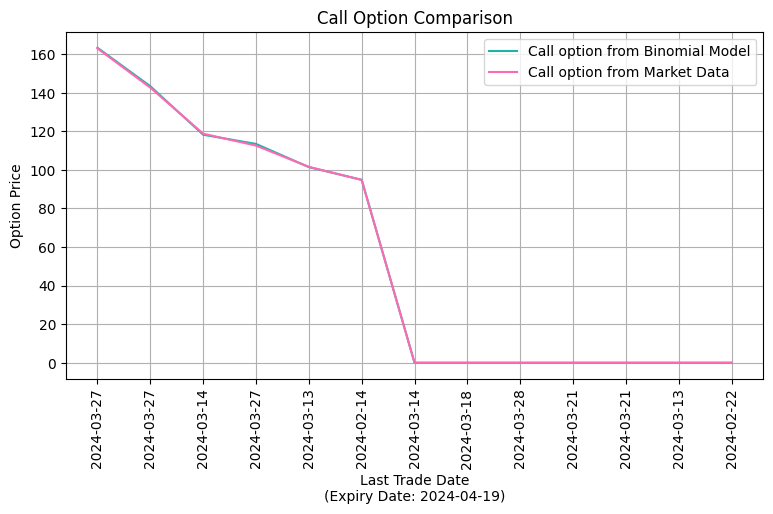

In [38]:
plt.figure(figsize=(9, 4.5))
plt.plot(calls.index, calls['optionPriceBinomial'], label='Call option from Binomial Model', c='lightseagreen')
plt.plot(calls.index, calls['lastPrice'], label='Call option from Market Data', c='hotpink')
plt.title('Call Option Comparison')
plt.ylabel('Option Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

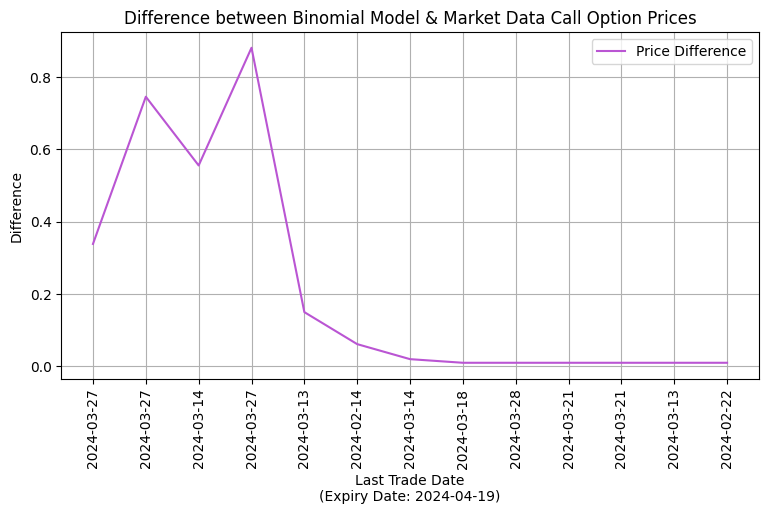

In [39]:
plt.figure(figsize=(9, 4.5))
differences = abs(calls['optionPriceBinomial'] - calls['lastPrice'])
plt.plot(range(len(calls)), differences, label='Price Difference', c='mediumorchid')
plt.title('Difference between Binomial Model & Market Data Call Option Prices')
plt.ylabel('Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

In [40]:
option_price_black_scholes = []
for i in range(len(calls)):
    T = calls['maturityPeriod'][i]/365
    n = calls['maturityPeriod'][i]
    K = calls['strike'][i]
    S0 = calls['initialPrice'][i]
    op_price = black_scholes_formula(S0, K, T, r, σ, "call")
    option_price_black_scholes.append(op_price)

In [41]:
calls['optionPriceBlackScholes'] = option_price_black_scholes
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial,optionPriceBlackScholes
0,2024-03-27,10.0,163.00,0.000010,REGULAR,USD,173.309998,23,163.338439,163.338439
1,2024-03-27,30.0,142.65,0.000010,REGULAR,USD,173.309998,23,143.395323,143.395323
2,2024-03-14,55.0,118.80,11.791995,REGULAR,USD,173.000000,36,118.244649,118.244649
3,2024-03-27,60.0,112.60,0.000010,REGULAR,USD,173.309998,23,113.480648,113.480648
4,2024-03-13,70.0,101.60,9.387699,REGULAR,USD,171.130005,37,101.450005,101.450005


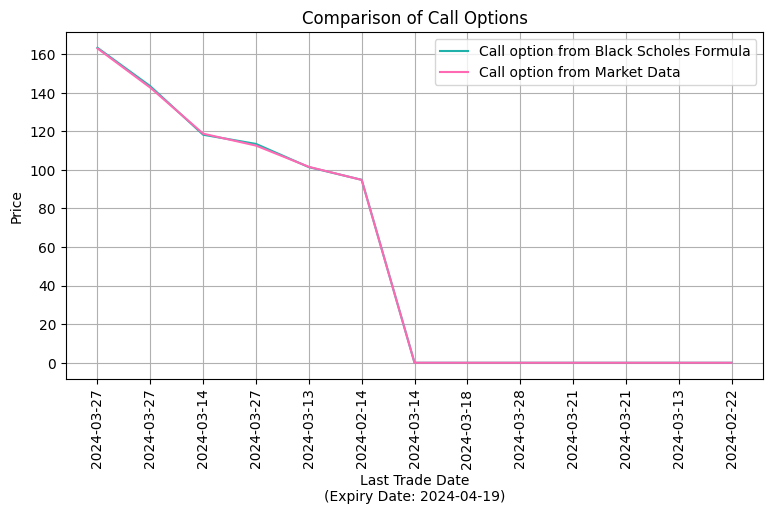

In [42]:
plt.figure(figsize=(9, 4.5))
plt.plot(calls.index, calls['optionPriceBlackScholes'], label='Call option from Black Scholes Formula', c='lightseagreen')
plt.plot(calls.index, calls['lastPrice'], label='Call option from Market Data', c='hotpink')
plt.title('Comparison of Call Options')
plt.ylabel('Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

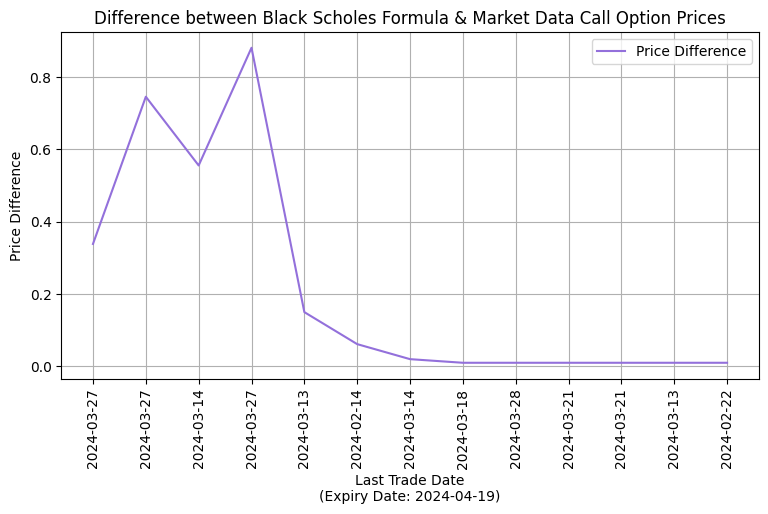

In [43]:
plt.figure(figsize=(9, 4.5))
differences = abs(calls['optionPriceBlackScholes'] - calls['lastPrice'])
plt.plot(calls.index, differences, label='Price Difference', c='mediumpurple')
plt.title('Difference between Black Scholes Formula & Market Data Call Option Prices')
plt.ylabel('Price Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

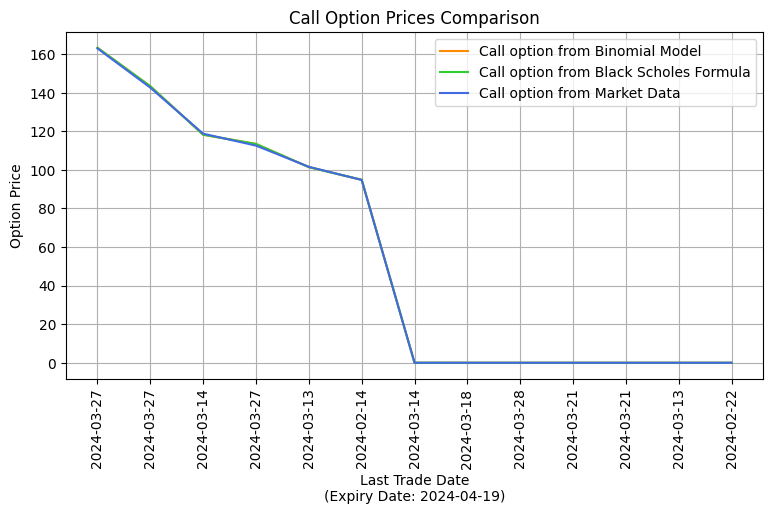

In [44]:
plt.figure(figsize=(9, 4.5))
plt.plot(calls.index, calls['optionPriceBinomial'], label='Call option from Binomial Model', c='darkorange')
plt.plot(calls.index, calls['optionPriceBlackScholes'], label='Call option from Black Scholes Formula', c='limegreen')
plt.plot(calls.index, calls['lastPrice'], label='Call option from Market Data', c='royalblue')
plt.title('Call Option Prices Comparison')
plt.ylabel('Option Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

## Put Option Comparison

In [45]:
puts['lastTradeDate'] = pd.to_datetime(puts['lastTradeDate']).dt.date
start_date = "2023-03-28"
end_date = "2024-04-01"
puts = puts[(puts['lastTradeDate'] >= pd.to_datetime(start_date).date()) & (puts['lastTradeDate'] <= pd.to_datetime(end_date).date())]
puts.reset_index(inplace = True, drop = True)
puts.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-02-20,20.0,0.01,0.500005,REGULAR,USD
1,2024-02-20,65.0,0.01,3.437501,REGULAR,USD
2,2024-03-22,70.0,0.01,0.500005,REGULAR,USD
3,2024-03-15,75.0,0.01,2.750003,REGULAR,USD
4,2024-03-05,85.0,0.02,2.531254,REGULAR,USD


In [46]:
initialPrice_put = []
for date in puts['lastTradeDate']:
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    initialPrice_put.append(initialPrice)
puts['initialPrice'] = initialPrice_put

In [47]:
maturity_periods_put = []
for i in puts['lastTradeDate']:
    maturity_period = (expiry_date - i ).days
    maturity_periods_put.append(maturity_period )

In [48]:
puts['maturityPeriod'] = maturity_periods_put
puts.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod
0,2024-02-20,20.0,0.01,0.500005,REGULAR,USD,181.559998,59
1,2024-02-20,65.0,0.01,3.437501,REGULAR,USD,181.559998,59
2,2024-03-22,70.0,0.01,0.500005,REGULAR,USD,172.279999,28
3,2024-03-15,75.0,0.01,2.750003,REGULAR,USD,172.619995,35
4,2024-03-05,85.0,0.02,2.531254,REGULAR,USD,170.119995,45


In [49]:
option_price_binomial = []
for i in range(len(puts)):
    T = puts['maturityPeriod'][i]/365
    n = puts['maturityPeriod'][i]
    K = puts['strike'][i]
    S0 = puts['initialPrice'][i]
    op_price = binomial_option_pricing(S0, K, T, r, σ, n, "put")
    option_price_binomial.append(op_price)

In [50]:
puts['optionPriceBinomial'] = option_price_binomial
puts

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial
0,2024-02-20,20.0,0.01,0.500005,REGULAR,USD,181.559998,59,0.000000
1,2024-02-20,65.0,0.01,3.437501,REGULAR,USD,181.559998,59,0.000000
2,2024-03-22,70.0,0.01,0.500005,REGULAR,USD,172.279999,28,0.000000
3,2024-03-15,75.0,0.01,2.750003,REGULAR,USD,172.619995,35,0.000000
4,2024-03-05,85.0,0.02,2.531254,REGULAR,USD,170.119995,45,0.000000
5,2024-02-14,230.0,46.04,0.000010,REGULAR,USD,184.149994,65,44.029995
6,2023-11-29,240.0,50.27,0.000010,REGULAR,USD,189.128662,142,47.051045
7,2024-01-22,245.0,51.60,0.000010,REGULAR,USD,193.642899,88,48.769686
8,2023-11-21,250.0,59.60,0.000010,REGULAR,USD,190.397049,150,55.218111
9,2024-02-29,255.0,74.35,0.000010,REGULAR,USD,180.750000,50,72.675976


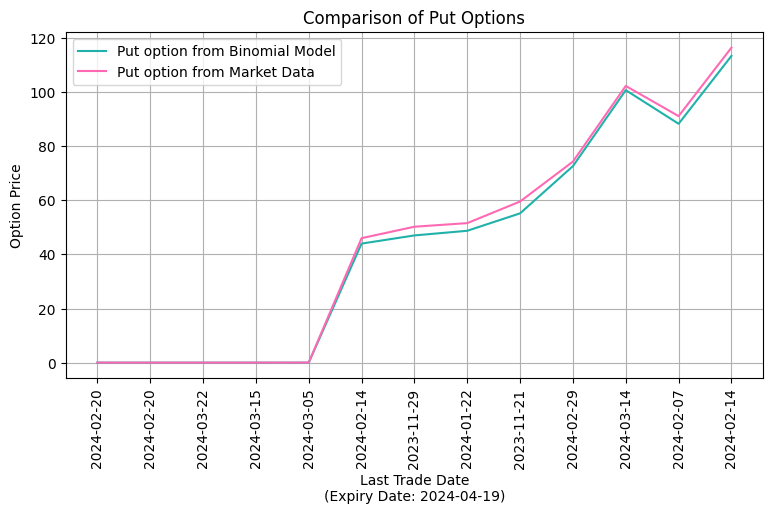

In [51]:
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, puts['optionPriceBinomial'], label='Put option from Binomial Model', c='lightseagreen')
plt.plot(puts.index, puts['lastPrice'], label='Put option from Market Data', c='hotpink')
plt.title('Comparison of Put Options')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.ylabel('Option Price')
plt.grid(True)
plt.legend()
plt.show()

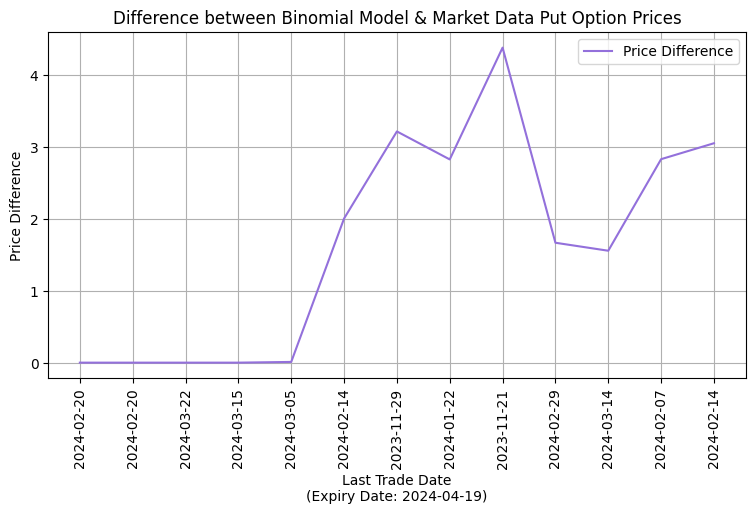

In [52]:
differences = abs(puts['optionPriceBinomial'] - puts['lastPrice'])
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, differences, label='Price Difference',  c='mediumpurple')
plt.title('Difference between Binomial Model & Market Data Put Option Prices')
plt.ylabel('Price Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

In [53]:
option_price_black_scholes = []
for i in range(len(puts)):
    T = puts['maturityPeriod'][i]/365
    n = puts['maturityPeriod'][i]
    K = puts['strike'][i]
    S0 = puts['initialPrice'][i]
    op_price = black_scholes_formula(S0, K, T, r, σ, "put")
    option_price_black_scholes.append(op_price)

In [54]:
puts['optionPriceBlackScholes'] = option_price_black_scholes
puts.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial,optionPriceBlackScholes
0,2024-02-20,20.0,0.01,0.500005,REGULAR,USD,181.559998,59,0.0,7.105427e-15
1,2024-02-20,65.0,0.01,3.437501,REGULAR,USD,181.559998,59,0.0,0.000000e+00
2,2024-03-22,70.0,0.01,0.500005,REGULAR,USD,172.279999,28,0.0,1.421085e-14
3,2024-03-15,75.0,0.01,2.750003,REGULAR,USD,172.619995,35,0.0,1.421085e-14
4,2024-03-05,85.0,0.02,2.531254,REGULAR,USD,170.119995,45,0.0,1.421085e-14


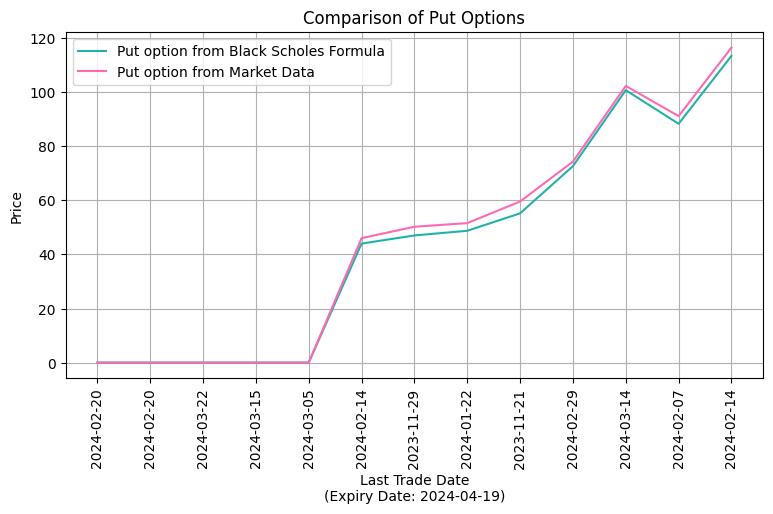

In [55]:
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, puts['optionPriceBinomial'], label='Put option from Black Scholes Formula', c='lightseagreen')
plt.plot(puts.index, puts['lastPrice'], label='Put option from Market Data', c='hotpink')
plt.title('Comparison of Put Options')
plt.ylabel('Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

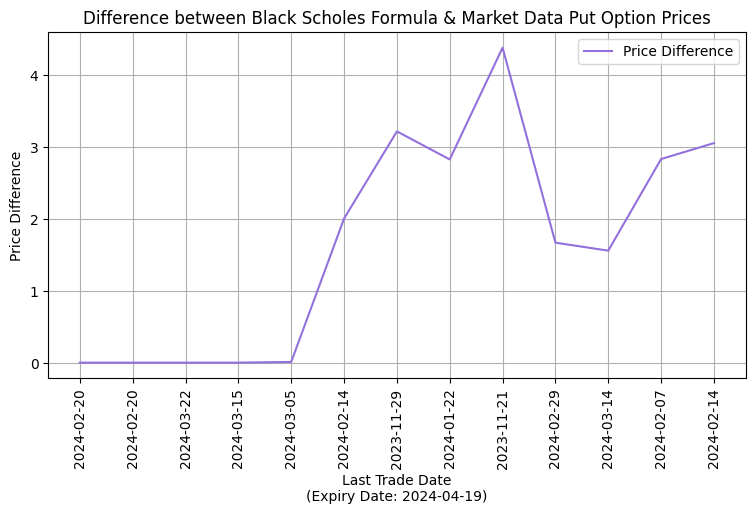

In [56]:
differences = abs(puts['optionPriceBlackScholes'] - puts['lastPrice'])
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, differences, label='Price Difference', c='mediumpurple')
plt.title('Difference between Black Scholes Formula & Market Data Put Option Prices')
plt.ylabel('Price Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

## Black Scholes vs Binomial vs Actual Market Data

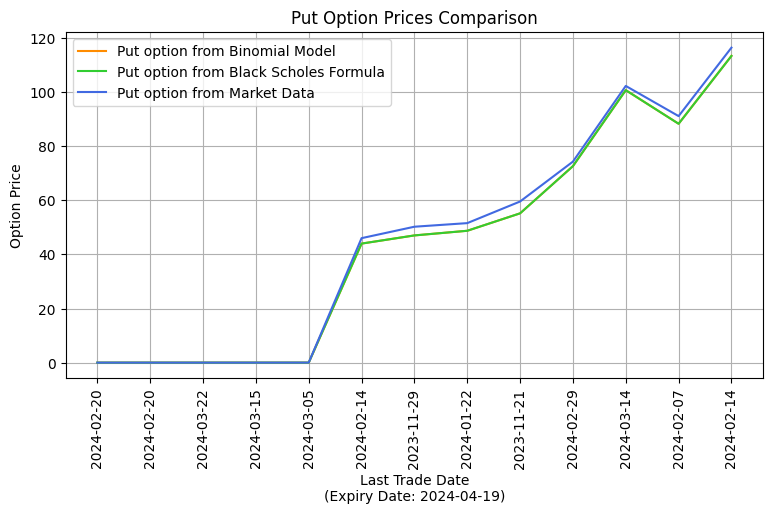

In [57]:
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, puts['optionPriceBinomial'], label='Put option from Binomial Model', c='darkorange')
plt.plot(puts.index, puts['optionPriceBlackScholes'], label='Put option from Black Scholes Formula', c='limegreen')
plt.plot(puts.index, puts['lastPrice'], label='Put option from Market Data', c='royalblue')
plt.title('Put Option Prices Comparison')
plt.ylabel('Option Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

In [58]:
def portfolio(S0, K, T, r, sigma, option='call', batch_size = 10):
    d1 = (np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    curr_delta = delta * batch_size

    if option == 'call':
        x = (batch_size * delta) / (1 - delta)
    elif option == 'put':
        x = (batch_size * (1 - delta)) / delta
        delta = delta - 1

    return x , delta

In [59]:
portfolio_call, delta_call = [], []
for i in range(len(calls)):
    date = calls.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = portfolio(initialPrice, calls.loc[i, 'strike'], calls.loc[i, 'maturityPeriod'], r, σ, option='call')
    portfolio_call.append(temp[0])
    delta_call.append(temp[1])

portfolio_put, delta_put = [], []
for i in range(len(puts)):
    date = puts.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = portfolio(initialPrice, puts.loc[i, 'strike'], puts.loc[i, 'maturityPeriod'], r, σ, option='put')
    portfolio_put.append(temp[0])
    delta_put.append(temp[1])

In [60]:
call_table = pd.DataFrame({
    'Strike (K)': calls['strike'],
    'Time to Maturity (T in days)': calls['maturityPeriod'],
    'Risk-Free Rate (r)': r,
    'Volatility (σ)': σ,
    'Call Delta': delta_call,
    'Portfolio (number of put options)': portfolio_call
})
call_table

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Call Delta,Portfolio (number of put options)
0,10.0,23,0.0452,0.196125,0.999998,4.925551e+06
1,30.0,23,0.0452,0.196125,0.999709,3.440274e+04
2,55.0,36,0.0452,0.196125,0.998385,6.182898e+03
3,60.0,23,0.0452,0.196125,0.996567,2.903240e+03
4,70.0,37,0.0452,0.196125,0.996999,3.322328e+03
5,90.0,65,0.0452,0.196125,0.999037,1.037587e+04
6,255.0,36,0.0452,0.196125,0.949650,1.886099e+02
7,265.0,32,0.0452,0.196125,0.930271,1.334115e+02
8,270.0,22,0.0452,0.196125,0.852555,5.782173e+01
9,275.0,29,0.0452,0.196125,0.906813,9.731094e+01


In [61]:
call_table = call_table.applymap('{:.6f}'.format)
call_table

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Call Delta,Portfolio (number of put options)
0,10.000000,23.000000,0.045200,0.196125,0.999998,4925551.458551
1,30.000000,23.000000,0.045200,0.196125,0.999709,34402.736174
2,55.000000,36.000000,0.045200,0.196125,0.998385,6182.897908
3,60.000000,23.000000,0.045200,0.196125,0.996567,2903.240164
4,70.000000,37.000000,0.045200,0.196125,0.996999,3322.328341
5,90.000000,65.000000,0.045200,0.196125,0.999037,10375.867728
6,255.000000,36.000000,0.045200,0.196125,0.949650,188.609857
7,265.000000,32.000000,0.045200,0.196125,0.930271,133.411459
8,270.000000,22.000000,0.045200,0.196125,0.852555,57.821730
9,275.000000,29.000000,0.045200,0.196125,0.906813,97.310942


In [62]:
put_data = pd.DataFrame({
    'Strike (K)': puts['strike'],
    'Time to Maturity (T in days)': puts['maturityPeriod'],
    'Risk-Free Rate (r)': r,
    'Volatility (σ)': σ,
    'Put Delta': delta_put,
    'Portfolio (number of call options)': portfolio_put
})
put_data

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Put Delta,Portfolio (number of call options)
0,20.0,59,0.0452,0.196125,-0.000033,0.000334
1,65.0,59,0.0452,0.196125,-0.000675,0.006750
2,70.0,28,0.0452,0.196125,-0.004577,0.045982
3,75.0,35,0.0452,0.196125,-0.003883,0.038985
4,85.0,45,0.0452,0.196125,-0.003155,0.031650
5,230.0,65,0.0452,0.196125,-0.006070,0.061067
6,240.0,142,0.0452,0.196125,-0.000069,0.000687
7,245.0,88,0.0452,0.196125,-0.001568,0.015709
8,250.0,150,0.0452,0.196125,-0.000046,0.000461
9,255.0,50,0.0452,0.196125,-0.018999,0.193665


In [63]:
put_data = put_data.applymap('{:.6f}'.format)
put_data

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Put Delta,Portfolio (number of call options)
0,20.000000,59.000000,0.045200,0.196125,-0.000033,0.000334
1,65.000000,59.000000,0.045200,0.196125,-0.000675,0.006750
2,70.000000,28.000000,0.045200,0.196125,-0.004577,0.045982
3,75.000000,35.000000,0.045200,0.196125,-0.003883,0.038985
4,85.000000,45.000000,0.045200,0.196125,-0.003155,0.031650
5,230.000000,65.000000,0.045200,0.196125,-0.006070,0.061067
6,240.000000,142.000000,0.045200,0.196125,-0.000069,0.000687
7,245.000000,88.000000,0.045200,0.196125,-0.001568,0.015709
8,250.000000,150.000000,0.045200,0.196125,-0.000046,0.000461
9,255.000000,50.000000,0.045200,0.196125,-0.018999,0.193665


---
## Implied Volatility
---

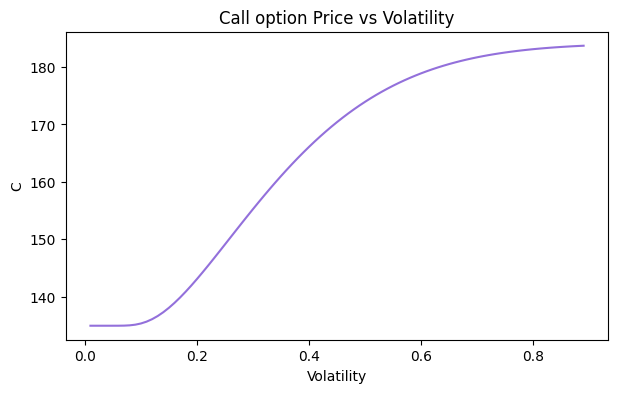

In [64]:
σs = np.arange(0.01, 0.9, 0.01)
C = [black_scholes_formula(S0, K, 40, r, σ, "call") for σ in σs]

plt.figure(figsize=(7, 4))
plt.plot(σs, C, c='mediumpurple')
plt.title("Call option Price vs Volatility")
plt.xlabel("Volatility")
plt.ylabel("C")
plt.show()

In [65]:
def newton_raphson(function, initial_guess, tolerance=1e-6, max_iterations=100, dh=1e-6):
    '''
    finds root of a function using newton-raphson method
    '''
    x = initial_guess
    for _ in range(max_iterations):
        fx = function(x)
        if abs(fx) < tolerance:
            return x
        dfx = (function(x + dh) - function(x)) / dh
        if dfx == 0:
            break
        x = x - fx / (dfx + 1e-6)
        if x < 0:
            x = dh
    return x

In [66]:
def implied_volatitlity(S0, K, r, T, CP, option='call'):
    def H(σ):
        return (black_scholes_formula(S0, K, T, r, σ, option) - CP)**2

    val = newton_raphson(H, 1.0)
    if np.abs(H(val) - H(0.0)) < 1e-5:
        return 0.0
    return val * 100

In [67]:
call_volatility = []
for i in range(len(calls)):
    date = calls.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = implied_volatitlity(initialPrice, calls.loc[i, 'strike'], r, calls.loc[i, 'maturityPeriod']/365, calls.loc[i, 'lastPrice'], option='call')
    call_volatility.append(temp)
    
put_volatility = []
for i in range(1, len(puts)):
    date = puts.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = implied_volatitlity(initialPrice, puts.loc[i, 'strike'], r, puts.loc[i, 'maturityPeriod']/365, puts.loc[i, 'lastPrice'], option='put')
    put_volatility.append(temp)

In [68]:
call_data = calls[['strike', 'lastPrice', 'maturityPeriod']].copy()
call_data.rename(columns={'strike': 'K', 'lastPrice': 'C', 'maturityPeriod': 'T'}, inplace=True)
call_data['S0'] = [google_data.loc[pd.to_datetime(date).strftime("%Y-%m-%d"), 'Close'] for date in calls['lastTradeDate']]
call_data['r'] = r
call_data['Implied Volatility(%)'] = call_volatility

In [69]:
call_data

,K,C,T,S0,r,Implied Volatility(%)
0,10.0,163.00,23,173.309998,0.0452,0.000000
1,30.0,142.65,23,173.309998,0.0452,0.000000
2,55.0,118.80,36,173.000000,0.0452,0.000000
3,60.0,112.60,23,173.309998,0.0452,0.000000
4,70.0,101.60,37,171.130005,0.0452,122.382022
5,90.0,94.81,65,184.149994,0.0452,0.000000
6,255.0,0.02,36,173.000000,0.0452,43.418295
7,265.0,0.01,32,173.720001,0.0452,46.802816
8,270.0,0.01,22,171.479996,0.0452,60.461879
9,275.0,0.01,29,171.369995,0.0452,54.562815


In [70]:
put_data = puts[['strike', 'lastPrice', 'maturityPeriod']].iloc[1:, :].copy()
put_data.rename(columns={'strike': 'K', 'lastPrice': 'P', 'maturityPeriod': 'T'}, inplace=True)
put_data['S0'] = [google_data.loc[pd.to_datetime(date).strftime("%Y-%m-%d"), 'Close'] for date in puts['lastTradeDate'].iloc[1:]]
put_data['r'] = r
put_data['Implied Volatility(%)'] = put_volatility

In [71]:
put_data

,K,P,T,S0,r,Implied Volatility(%)
1,65.0,0.01,59,181.559998,0.0452,83.880088
2,70.0,0.01,28,172.279999,0.0452,105.885705
3,75.0,0.01,35,172.619995,0.0452,89.250878
4,85.0,0.02,45,170.119995,0.0452,70.557988
5,230.0,46.04,65,184.149994,0.0452,42.233988
6,240.0,50.27,142,189.128662,0.0452,34.462693
7,245.0,51.60,88,193.642899,0.0452,41.001378
8,250.0,59.60,150,190.397049,0.0452,39.742736
9,255.0,74.35,50,180.750000,0.0452,63.390324
10,275.0,102.34,36,173.000000,0.0452,92.962655


---